In [2]:
import numpy as np
from keras import backend as K
from keras.objectives import mean_squared_error
def log_poisson(y_true, log_y_pred):
    return K.mean(K.exp(log_y_pred) - y_true * log_y_pred, axis=-1)

def poi_gau_mix(y_true, log_y_pred):
    return log_poisson(y_true, log_y_pred) + 0.01*mean_squared_error(y_true, K.exp(log_y_pred))

Using Theano backend.


In [30]:
# from keras.layers import Embedding, Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Dense, Dropout, Activation, Embedding, Input
from keras.models import Model
from keras.constraints import MaxNorm
from keras.layers.advanced_activations import ELU

from keras.models import Model, Sequential
from keras.layers import Dense, LSTM

# create the model
input_dim = 16
sequence_len = 240000
embed_dim = 128
input_shape = (sequence_len, input_dim)

print('Build model...')
mo = Sequential()
# mo.add( Input(shape=(input_dim,), dtype='int32', name = 'input1', input_length =sequence_len ))
# em = Embedding(output_dim=3,input_dim=4,input_length=4) (a)

# mo.add(Embedding(input_dim, embed_dim, dropout=0.2, input_length=input_length))
# mo.add(Input(shape=(input_dim,)))
mo.add(LSTM(embed_dim, dropout_W=0.2, dropout_U=0.2, input_shape=input_shape))  # try using a GRU instead, for fun
mo.add(Dense(1))
mo.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
mo.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print(model.summary())
# # model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)

Build model...


In [4]:
filepath = "mo1keras"
# mo.load_weights(filepath)

In [5]:
mo.optimizer.lr.set_value(.01)

In [6]:
from keras.callbacks import LearningRateScheduler
def scheduler(epoch):
    if epoch == 15:
        mo.optimizer.lr.set_value(.01)
    if epoch == 20:
        mo.optimizer.lr.set_value(.005)
    return float(mo.optimizer.lr.get_value())

change_lr = LearningRateScheduler(scheduler)

In [8]:
from scipy.io import loadmat
import six
def mat_to_data(path):
    mat = loadmat(path)
    names = mat['dataStruct'].dtype.names
    ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
    for kk,vv in six.iteritems(ndata):
#         print(vv.shape)
        if vv.shape == (1,1):
            ndata[kk] = vv[0,0]
    return ndata

def get_label(infile):
    return infile.split(".")[-2][-1] == "0"


infile = "./data/1_1_0.mat"
data = mat_to_data(infile)
label = get_label(infile)

In [33]:
import os
def filegen(folder, BATCH_SIZE = 64):
    xx = []
    yy = []
    infiles = os.listdir(folder)
    NUM_FILES = len(infiles)
    for nn, ff in enumerate(infiles):
        label = get_label(ff)
        data = mat_to_data(infile)
#         yield np.dstack(data["data"]).transpose(0,2,1), np.array([[label]])
        xx.append(data["data"])
        yy.append(label)
        if ((nn+1) % BATCH_SIZE == 0) or ((nn+1)==NUM_FILES):
            data = np.dstack(xx).transpose(2,0,1)
            label = np.array(yy)[:,np.newaxis]
#             print(data.shape, label.shape)
            xx = []
            yy = []
            yield data, label


datadir = "data/"
BATCH_SIZE = 4
gen = filegen(datadir, BATCH_SIZE = BATCH_SIZE)

for xx, yy in gen:
    print(xx.shape, yy.shape)
    pass

(4, 240000, 16) (4, 1)


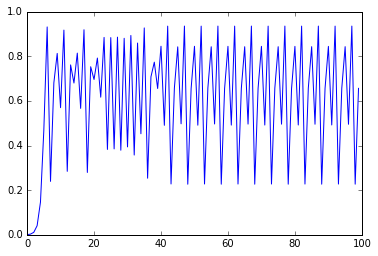

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline

def logistic_map(x0, r, N = 100):
    x=x0
    nn = 0
    yield x
    while True:
        nn += 1
        if nn >= N:
            raise StopIteration
        x = r*x*(1-x)
        yield x
        
        
def F(N):
    a,b = 0, 10
    nn = 0
    yield a, b
    while True:
        nn += 1
        if nn >= N:
            raise StopIteration
        a, b = a - 2*b + 1, a - 2*b - 1
        yield a, b
        
# x,y = list(zip(*[x for x  in F(10)]))
# plt.plot(x)
# plt.plot(y)

# plt.plot(list(logistic_map(0.6,3.5)))
plt.plot(list(logistic_map(7.910e-4,3.741)))

In [76]:
list(zip(*[x for x  in F(10)]))

[(0, -19, 24, -19, 24, -19, 24, -19, 24, -19),
 (10, -21, 22, -21, 22, -21, 22, -21, 22, -21)]

imdb example:

    X (25000 , 80)
      (num_samples, seq_len)
     
eeg:

    X (num_samples, seq_len, embedding_dim)

In [34]:
from itertools import cycle
datadir = "data/"
BATCH_SIZE = 4
gen = cycle(filegen(datadir, BATCH_SIZE = BATCH_SIZE))
# print(type(gen))
# print(gen.next())
mo.fit_generator(gen, nb_worker=1,
                 nb_epoch=300, samples_per_epoch = BATCH_SIZE,
                 callbacks=[change_lr])

Epoch 1/300
4/4 [==============================] - 240s - loss: 0.8891 - acc: 0.2500
Epoch 2/300
4/4 [==============================] - 190s - loss: 0.7247 - acc: 0.5000
Epoch 3/300
4/4 [==============================] - 192s - loss: 0.8183 - acc: 0.5000
Epoch 4/300
4/4 [==============================] - 198s - loss: 0.8754 - acc: 0.2500
Epoch 5/300
4/4 [==============================] - 186s - loss: 0.5445 - acc: 1.0000
Epoch 6/300
4/4 [==============================] - 188s - loss: 0.8027 - acc: 0.5000
Epoch 7/300


KeyboardInterrupt: 